# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         
    env_info = env.reset(train_mode=False)[brain_name]     
    states = env_info.vector_observations                  
    scores = np.zeros(num_agents)                          
    counter = 0
    while True:
        counter += 1
        actions = np.random.randn(num_agents, action_size) 
        actions = np.clip(actions, -1, 1)                  
        env_info = env.step(actions)[brain_name]           
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                         
        dones = env_info.local_done                        

        scores += env_info.rewards                        
        states = next_states                               
        if np.any(dones):                                  
            break
    print('Total score (averaged over agents) this episode: {} {}'.format(np.mean(scores),counter))


Total score (averaged over agents) this episode: -0.004999999888241291 15
Total score (averaged over agents) this episode: -0.004999999888241291 16
Total score (averaged over agents) this episode: -0.004999999888241291 14
Total score (averaged over agents) this episode: -0.004999999888241291 13
Total score (averaged over agents) this episode: -0.004999999888241291 21


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
from maddpg import MADDPGAgent
from collections import deque
import matplotlib.pyplot as plt
import torch

o_dim = 24
a_dim = 2
x_dim = num_agents * o_dim

LR_ACTOR = 1e-2   
LR_CRITIC = 1e-4       
LEARN_NUM = 1
BATCH_SIZE = 128        
GAMMA = .99           
TAU = 0.001             
BUFFER_SIZE = int(1e6)  

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.99

maddpg = MADDPGAgent(num_agents, x_dim, o_dim, a_dim, 
                     lr_actor = LR_ACTOR, lr_critic = LR_CRITIC, learn_num = LEARN_NUM,
                     batch_size = BATCH_SIZE, gamma = GAMMA, tau = TAU, 
                     buffer_size = BUFFER_SIZE, seed = 1234)

NUM_EPISODES = 2500
PRINT_EVERY = 100

In [7]:
# train agents

score_list = []
score_window = deque(maxlen = PRINT_EVERY)


eps = eps_start
best_score = 0.5
for e in range(1, NUM_EPISODES+1):  
    env_info = env.reset(train_mode=True)[brain_name]   # reset environment
    states = env_info.vector_observations 
    scores = np.zeros(num_agents)  
    while True:
        actions = maddpg.get_actions(states, eps)
        
        env_info = env.step(actions)[brain_name]  
        next_states = env_info.vector_observations   
        dones = env_info.local_done
        rewards = env_info.rewards
        
        maddpg.step(states, actions, rewards, next_states, dones )
        
        states = next_states 
        scores += rewards 
        if np.any(dones):                                  
            break   
    
    eps = max(eps_end, eps_decay*eps) # decrease exploartion
    max_score = np.max(scores) # max score among the agents
    
    score_window.append(max_score)
    mean_score = np.mean(score_window)
    score_list.append([max_score, mean_score])
    
    maddpg.lr_scheduler()
    
    print('\rEpisode {}\t score {:8.2f}\t mean score {:8.2f}'.format(e, max_score, mean_score), end = "")
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\t score {:8.2f}\t mean score {:8.2f}'.format(e, max_score, mean_score))
        
    if mean_score>= best_score:
        print('\rEpisode {}\t score {:8.2f}\t mean score {:8.2f}\t saved!'.format(e, max_score, mean_score))
        best_score = mean_score
        for i, agent in enumerate(maddpg.agents):
            torch.save(agent.actor.state_dict(), 'checkpoint_actor'+str(i)+'.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic'+str(i)+'.pth')

Episode 100	 score     0.00	 mean score     0.00
Episode 200	 score     0.00	 mean score     0.01
Episode 300	 score     0.10	 mean score     0.03
Episode 400	 score     0.00	 mean score     0.01
Episode 500	 score     0.00	 mean score     0.00
Episode 600	 score     0.00	 mean score     0.00
Episode 700	 score     0.00	 mean score     0.00
Episode 800	 score     0.00	 mean score     0.01
Episode 900	 score     0.00	 mean score     0.02
Episode 1000	 score     0.00	 mean score     0.02
Episode 1100	 score     0.09	 mean score     0.02
Episode 1200	 score     0.10	 mean score     0.04
Episode 1300	 score     0.10	 mean score     0.05
Episode 1400	 score     0.09	 mean score     0.07
Episode 1500	 score     0.40	 mean score     0.13
Episode 1600	 score     0.70	 mean score     0.15
Episode 1700	 score     0.80	 mean score     0.14
Episode 1800	 score     0.20	 mean score     0.32
Episode 1900	 score     0.10	 mean score     0.26
Episode 2000	 score     0.10	 mean score     0.49
Episode 2

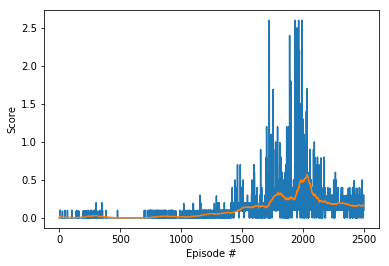

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
# watch trained agents
for i, agent in enumerate(maddpg.agents):
    agent.actor.load_state_dict(torch.load('checkpoint_actor'+str(i)+'.pth'))

for i in range(5):                                         
    env_info = env.reset(train_mode=False)[brain_name]     
    states = env_info.vector_observations                  
    scores = np.zeros(num_agents)                          
    while True:
        actions = maddpg.get_actions(states, eps)               
        env_info = env.step(actions)[brain_name]           
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                         
        dones = env_info.local_done                        

        scores += env_info.rewards                        
        states = next_states                               
        if np.any(dones):                                  
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.7950000120326877
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.44500000681728125
Total score (averaged over agents) this episode: 0.04000000096857548
Total score (averaged over agents) this episode: 0.1450000023469329


When finished, you can close the environment.

In [11]:
env.close()